In [67]:
import pandas as pd
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
import numpy as np

color_data_integer = pd.read_csv("wcs/term.txt", sep="\t", names=["language", "speaker", "chip", "word"])


In [68]:
chip2lab = pd.read_csv("wcs/cnum-vhcm-lab-new.txt", sep="\t", header=0, index_col="#cnum")
chip2lab = chip2lab.sort_values(by="#cnum")[["L*", "a*", "b*"]]
color_data_integer = color_data_integer.merge(chip2lab, left_on="chip", right_on="#cnum", how="left")

In [69]:
from scipy.stats import expon
def prior_H(hypotheses):
    return [expon.pdf(h.n_components, 0.001) for h in hypotheses]

def prior_C(chips):
    """returns the prior probability of c for each c in chips"""
    return np.full((len(chips),), 1/330)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [11:17<00:00,  6.16s/it]


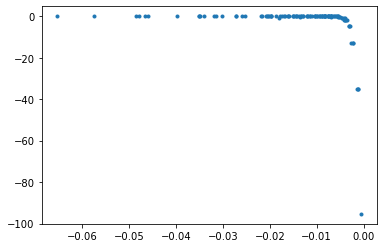

In [70]:
import matplotlib.pyplot as plt
from tqdm import tqdm
inf_loss = []
complexity = []
for language, elicitations in tqdm(color_data_integer.groupby('language')):
    np.seterr(divide='ignore')
    #elicitations["Term"], _ = pd.factorize(elicitations["Term"])
    
    # features are L*a*b* and one-hot color term for each chip elicitation
    data =  pd.concat([
                elicitations[["L*", "a*", "b*"]], 
                pd.get_dummies(elicitations.word)
    ], axis=1).to_numpy()
    
    # fit GMM -- should eventually fit several of these
    hypothesis = GaussianMixture(n_components=max(pd.factorize(elicitations.word)[0]), random_state=42).fit(data)
    
    H = [hypothesis]
    
    ### COMPUTE INFORMATION LOSS (log likelihood) ###
    inf_loss.append(hypothesis.score(data)/data.shape[0])
    
    ### COMPUTE COMPLEXITY (mutual information) ###
    # p(c|h) for all h in H
    pcH = np.array([h.predict_proba(data[:330]).sum(axis=1) for h in H])
    
    lratio = np.log(
        pcH / prior_C(pd.factorize(elicitations.word)[0][:330]) # prior probability over 330 chips is uniform.
    ) 
    lratio[lratio == -np.inf] = 0
    pH = prior_H(H)

    # I(H;C) -- mutual information between the hypothesis and the WCS data
    MI_HC = -pcH * pH * lratio 
    MI_HC = MI_HC.sum(axis=0) # sum over hypotheses

    MI_HC = sum(MI_HC) # sum over chips
    
    complexity.append(MI_HC)
    
plt.plot([-x for x in inf_loss], complexity, '.')
plt.show()




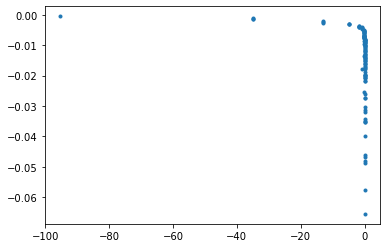

In [53]:
plt.plot(complexity, inf_loss, '.')
#plt.xlim([0, 0.003])
plt.show()


1. P(H)?
2. P(C)?
3. Inputs to GMM -- 1 hot

simulate actual kid learning
use schedule m
p(C) = capacity achieving prior noga (need to optimize) -- blahut arimoto
calculate likelihood over all the color chips and average, multiply by N to get number of data points
that is beta for tradeoff

p(H) dirichlet process prior -- favor as few lumps (gaussians) as possible
penalize the gaussian prior on how close the means and std dev
8 terms in english, 8 gaussians, reward gaussians that are basically the same thing
reward gaussian with similar means
reward wider std deviation


ideally variational/dirichlet

generate hypotheses with a schedule, each hypotheses get n data points on the schedule
oversample lower end

information loss not on training data but on WCS data (uniform)

multiply the plot (information loss) by N the number of data points for the hypothesis (dont)

or just plot at N=1 :D
